<img src="https://amp.businessinsider.com/images/5b6db1a6e199f319008b4ee6-1920-960.jpg">

In [1]:
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import pandas as pd
import numpy as np
import folium
import requests

import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 

## Section 1: Collect Population Density Data for US Cities

### Section 1A: Web scraping population density data with BeautifulSoup

In [2]:
website_url = requests.get('https://www.governing.com/gov-data/population-density-land-area-cities-map.html').text

In [3]:
# get the table
soup = BeautifulSoup(website_url,'lxml')
my_table = soup.find("table", { "class":"dataTable"})

In [4]:
# Function: Convert BeautifulSoup tags to string list
def convert_to_list(bs4row):
    list_bs4row = bs4row.findAll(["td","th"])
    return [bs4.get_text().strip() for bs4 in list_bs4row]

In [5]:
# get the table
soup = BeautifulSoup(website_url,'lxml')
my_table = soup.find("table", { "class":"dataTable"})
rows=my_table.findAll("tr")

# convert to list of list
my_data = [convert_to_list(r) for r in rows[1:]]

### Section 1B: Create population density dataframe 

In [6]:
df = pd.DataFrame(my_data,columns=['City','Population_Density','Population','Land_Area'])

# convert the number from string to integer
for col in df.columns[1:]:
    df[col]=df[col].apply(lambda s: int(s.replace(',','')))

print('Number of US city: {}'.format(len(df)))


Number of US city: 754


In [7]:
df.head()

,City,Population_Density,Population,Land_Area
0,"New York, New York",28211,8537673,303
1,"Los Angeles, California",8484,3976322,469
2,"Chicago, Illinois",11883,2704958,228
3,"Houston, Texas",3842,2303482,600
4,"Phoenix, Arizona",3126,1615017,517


In [8]:
df.describe()

,Population_Density,Population,Land_Area
count,754.000000,7.540000e+02,754.000000
mean,4242.729443,1.646172e+05,55.015915
std,4323.792554,3.973563e+05,95.695024
min,172.000000,5.007700e+04,1.000000
25%,2076.000000,6.417050e+04,19.000000
50%,3128.500000,8.669450e+04,31.500000
75%,4720.000000,1.380125e+05,54.750000
max,54138.000000,8.537673e+06,1705.000000


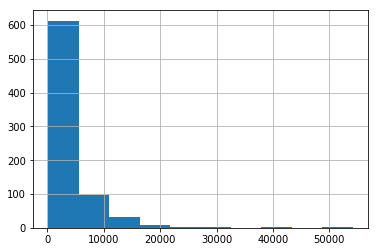

In [9]:
# Plot histogram of population density
df['Population_Density'].hist(bins=10)

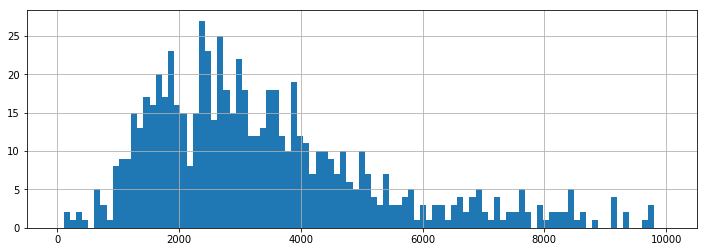

In [10]:
# Histogram of city with density less than 10,000
df['Population_Density'].hist(bins=np.linspace(0,10000,100),figsize=[12,4])

### Section 1C: Obtain latitude and longitude coordinates of these cities

In [11]:
def get_latitude_longitude(city):
    geolocator = Nominatim(user_agent="my-application")
    try:
        location = geolocator.geocode(city)
        if location is not None:
            return location.latitude, location.longitude
        else:
            return np.NaN,np.NaN
    except GeocoderTimedOut:
        return get_latitude_longitude(city)

In [12]:
# Get the latitude and longitude for each city
df['Latitude'],df['Longitude'] = zip(*df['City'].apply(get_latitude_longitude))

In [13]:
# Remove city without latitude and longitude
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

## Section 2: Plot the Population Density of US Cities

In [14]:
# create map
US_lat, US_long = get_latitude_longitude('US')
map_US = folium.Map(location=[US_lat,US_long], zoom_start=4)

In [15]:
# set color scheme
cmap = plt.cm.get_cmap('YlOrRd')
norm = colors.LogNorm(vmin=df['Population_Density'].min(), vmax=df['Population_Density'].max())

In [16]:
# add markers to the map
markers_colors = []
for lat, lon, poi, den in zip(df['Latitude'], df['Longitude'], df['City'], df['Population_Density']):
    label = folium.Popup(str(poi) + '\nDensity:' + str(den), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors.rgb2hex(cmap(norm(den))),
        fill_color=colors.rgb2hex(cmap(norm(den))),
        weight=1,
        opacity=0.3,
        fill_opacity=0.3).add_to(map_US)
map_US

## Section 3: Collect the Nearby Venues Using Foursquare API

### Section 3A: Collect the nearby venues based on the geographic coordinate of US cities

In [17]:
# @hidden_cell
CLIENT_ID = 'CRDS4XWDD4KPADKBVJP1JE5NW3AYATHVMUCCUC4ZFNIWNJZ5' # your Foursquare ID
CLIENT_SECRET = 'ZBKR4ETVK14UV2SMZRJ1OCPSLAZFF2K2RPBEWFEKWHFVFHTE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
df_city_venues = getNearbyVenues(df['City'],df['Latitude'],df['Longitude'])

### Section 3B: Calculate the frequency of nearby venues for each US city 

In [20]:
df_density = df[['City','Population_Density']]

In [21]:
# one hot encoding
df_onehot = pd.get_dummies(df_city_venues[['Venue Category']], prefix="", prefix_sep="")
df_onehot['City'] = df_city_venues['City']
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
df_venues_freq_by_city = df_onehot.groupby('City').mean()

df_venues_freq_by_city_density = pd.merge(df_venues_freq_by_city, df_density, on=['City'], how='left')
df_venues_freq_by_city_density.head()

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Population_Density
0,"Abilene, Texas",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,...,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1145
1,"Akron, Ohio",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.024390,...,0.012195,0.012195,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3186
2,"Albany, Georgia",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.173913,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1339
3,"Albany, New York",0.0,0.010638,0.0,0.0,0.0,0.0,0.0,0.0,0.042553,...,0.000000,0.000000,0.010638,0.0,0.0,0.0,0.0,0.0,0.0,4587
4,"Albany, Oregon",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,...,0.000000,0.032258,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3034


## Section 4: Correlation Between the Venues Frequency and Population Density

In [22]:
df_corr = pd.DataFrame(df_venues_freq_by_city_density.corr()['Population_Density'])

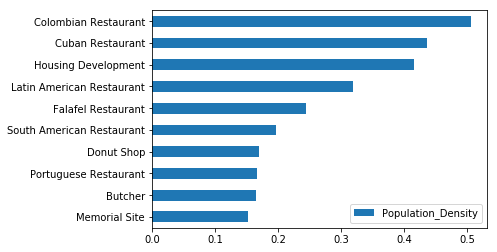

In [23]:
df_corr = df_corr.head(len(df_corr)-1).sort_values(['Population_Density'])
df_corr.tail(10).plot.barh()

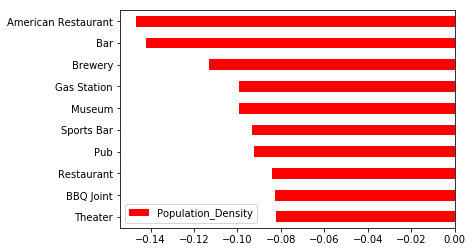

In [24]:
df_corr = df_corr.head(len(df_corr)-1).sort_values(['Population_Density'],ascending=False)
df_corr.tail(10).plot.barh(color='r')

## Section 5: Predict Population Density with Machine Learning Approaches

In [25]:
def set_density_class(density):
    if density > 6000:
        return 1
    elif density < 2000:
        return 0
    else:
        return np.NaN

In [26]:
df['Density_class'] = df['Population_Density'].apply(set_density_class)
df_class = df[['City','Density_class']]

In [27]:
df_class = df[['City','Density_class']]

In [28]:
df_venues_freq_by_city_density_class = pd.merge(df_venues_freq_by_city, df_class, on=['City'], how='inner')
df_venues_freq_by_city_density_class.dropna(subset=['Density_class'],inplace=True)
df_venues_freq_by_city_density_class.shape

(299, 541)

In [29]:
features = df_venues_freq_by_city_density_class.columns[1:-1]
X = df_venues_freq_by_city_density_class[features].values
y = df_venues_freq_by_city_density_class['Density_class'].values

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### K Nearest Neighbor (KNN)

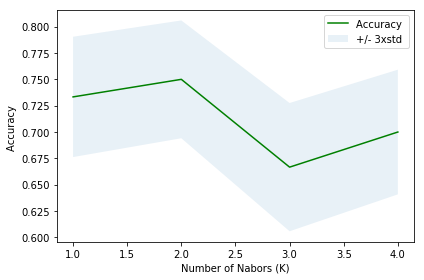

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
Ks = 5
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()


In [32]:
# Report maximum acccuracy and the best K
max_acc = max(mean_acc)
KNN_maxK = mean_acc.argmax()+1

print("KNN's max accuary is {:.3f}, it occurs when k = {}".format(max_acc,KNN_maxK))

KNN's max accuary is 0.750, it occurs when k = 2


In [33]:
neigh = KNeighborsClassifier(n_neighbors=KNN_maxK).fit(X_train,y_train) # The best k is therefore used for the model 
y_KNN = neigh.predict(X_test)

### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

DTree = DecisionTreeClassifier(criterion='entropy',max_depth =4).fit(X_train,y_train)
y_DTree = DTree.predict(X_test)

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear',class_weight = 'balanced').fit(X_train,y_train)
y_LR = LR.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

algorithms = ['KNN (Best K={})'.format(KNN_maxK),'Decision Tree','Logistic Regression']

y_preds = [y_KNN,y_DTree,y_LR]

# accuracy
accuracy = []
for y_pred in y_preds:
    accuracy.append(accuracy_score(y_test, y_pred))

# F1-score
F1scores = []
for y_pred in y_preds:
    F1scores.append(f1_score(y_test, y_pred, pos_label=1))

# Create dataframe for output
df_eva = pd.DataFrame({"Accuracy":accuracy, "F1-score":F1scores}, index=algorithms)

In [37]:
df_eva.round(3)

,Accuracy,F1-score
KNN (Best K=2),0.750,0.681
Decision Tree,0.717,0.514
Logistic Regression,0.650,0.512
